# Solving Heisenberg model and calculating the entanglement entropy

[![Download Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/mindspore_heisenberg_model_and_entanglement.ipynb)&emsp;
[![Download Code](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/mindspore_heisenberg_model_and_entanglement.py)&emsp;
[![View source on Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_en/mindspore_heisenberg_model_and_entanglement.ipynb)

## Overview
Heisenberg model is a spin-based system of statistic mechanics, which is frequently used to study the phase transition and the phenomennon of critical point. In the research of variational quantum algorithm, Heisenberg model always is a hot topic due to its clear and simple physics picture.

This tutorial starts from Heisenberg model and expands into following threes aspects. At the end of this tutorial, the parameters, including entanglement entropy, norm of the gradient, etc, will be discussed in the process of optimizing the Heisenberg model.

- Building Heisenberg model;
- Calculating entanglement entropy;
- Optimizing the model and verifying the results.

## Building Heisenberg model from a graph

As we know, the Hamiltonian of Heisenberg model can be writen as：
$$
H=\sum_{i, j \in V_{\mathcal{G}}} J\left(\sigma_i^z \sigma_j^z+\sigma_i^y \sigma_j^y+\sigma_i^x \sigma_j^x\right)+h_z \sum_{i=1}^N \sigma_i^z
$$
, where $V_{\mathcal{G}}$ represents the set of the vertex of the graph $\mathcal{G}$。$N$ is the number of the nodes, which equals to the number of qubtis for simulation in this tutorial. According to this formula, we can use `networkx` to generate a graph, and obtain the Heisenberg model by searching the nodes and edges of the graph.

First we import some package:

In [17]:
import networkx as nx
from mindquantum import QubitOperator, Hamiltonian

Then, for simplicity, we use `nx.random_graphs.random_regular_graph()` to generate the graph, which should be like a triangular:

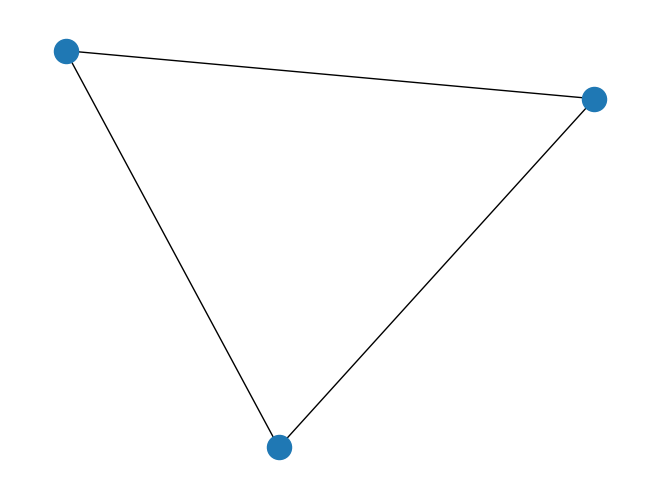

In [18]:
graph = nx.random_graphs.random_regular_graph(2, 3)
nx.draw(graph)

Then, we apply the formula of Heisenberg model. Assuming $J=h_z=1$, we have:

In [19]:
J = 1
h_z = 1
ham = QubitOperator()
for i in graph.edges:
    ham += J * QubitOperator(f'X{i[0]} X{i[1]}')
    ham += J * QubitOperator(f'Y{i[0]} Y{i[1]}')
    ham += J * QubitOperator(f'Z{i[0]} Z{i[1]}')

for i in graph.nodes:
    ham += h_z * QubitOperator(f'Z{i}')

print(ham)

1 [X0 X1] +
1 [Y0 Y1] +
1 [Z0 Z1] +
1 [X0 X2] +
1 [Y0 Y2] +
1 [Z0 Z2] +
1 [X1 X2] +
1 [Y1 Y2] +
1 [Z1 Z2] +
1 [Z0] +
1 [Z1] +
1 [Z2] 


Finally, we figure out how to build a Heisenberg model. For convinience, we can write a class for it:

In [4]:
class HeisenbergModel:
    
    def __init__(self, J, h_z, graph: nx.Graph):
        self.J = J
        self.h_z = h_z
        self.graph = graph
        self.n_qubits = graph.number_of_nodes()

    def ham(self) -> Hamiltonian:
        ham = QubitOperator()
        for i in self.graph.edges:
            ham += self.J * QubitOperator(f'X{i[0]} X{i[1]}')
            ham += self.J * QubitOperator(f'Y{i[0]} Y{i[1]}')
            ham += self.J * QubitOperator(f'Z{i[0]} Z{i[1]}')
        for i in self.graph.nodes:
            ham += self.h_z * QubitOperator(f'Z{i}')
        return Hamiltonian(ham)

    def draw_graph(self) -> None:
        nx.draw(self.graph)

## Calculating bipartite entropy

```mindquantum``` is a vector-based simulator, which means the quantum state can only be simulated as pure state. If we want to calculating the entropy, the reduced density matrix must be obtained. We have to do something called 'partial trace'.

To address this issue, we can first compute the density matrix of the whole system by $\rho=|\psi\rangle\langle\psi|$ ，where$|\psi\rangle$ can be obtained by ```Simulator.get_qs()```，then by doing ```numpy.outer(psi,psi.conjugate())```we can obtain $\rho$. Note that this is a pure state such that $\mathrm{rank}(\rho)=1$。\.

Then, let me show you a function that can be used in ```mindquantum``` simulator to calculate the reduced density matrix：

In [5]:
import numpy as np

def get_rs(rho: np.array, list_qubits2keep: list) -> np.array:
    list_qubits2traceout = list(set(range(int(np.log2(len(rho))))) - set(list_qubits2keep))
    counter_qubits = int(np.log2(len(rho)))
    rho_tensor = rho.reshape((2, 2) * counter_qubits)
    for i in list_qubits2traceout:
        index2trace = i - list_qubits2traceout.index(i)
        rho_tensor = np.trace(rho_tensor, axis1=counter_qubits - 1 - index2trace,
                              axis2=2 * counter_qubits - 1 - index2trace)
        counter_qubits += -1
    rho_rs = rho_tensor.reshape(2 ** counter_qubits, 2 ** counter_qubits)
    return rho_rs

The method is based on```numpy.reshape()``` and ```numpy.trace()``` to different axis, which is just some complicated contraction of indice. This short piece of code is not easy to understand so just use it. Here we can test this method by constructing such a simple ciruict:

In [20]:
from mindquantum import Circuit, H, CNOT, Simulator

circ = Circuit([H.on(0), CNOT.on(1, 0)])
circ.svg()

This is a typical Bell state circuit, we can simulate this circuit on the simulator and calculate the density matrix by outer product:

In [21]:
sim = Simulator('mqvector', 2)
sim.apply_circuit(circ)
psi = sim.get_qs()
rho = np.outer(psi, psi.conjugate())

`rho` is the density matrix of the whole system. Then，if we just want to keep the space of `q0` and trace out the others, we can call `get_qs` like this:

In [22]:
get_rs(rho, [0])

array([[0.5+0.j, 0. +0.j],
       [0. +0.j, 0.5+0.j]])

The first argument is the density matrix and the second arguments is the list of indice of the subsystems we want to keep. It is obvious that this reduced density matrix is the maximally mixed state, $I/2$.

After obtaining the reduced density matrix, it becomes pretty easy to calculate bipartite entropy. I just lists these methods here. They are simple:

In [23]:
def purity(density_matrix):
    """
    :param density_matrix: reduced density matrix to compute purity;
    :return: purity = Tr(rho^2).
    """
    rho2 = np.matmul(density_matrix, density_matrix)
    return np.trace(rho2).real


def s2(density_matrix):
    """
    :param density_matrix: reduced density matrix to compute entropy;
    :return: second Renyi entropy.
    """
    rho2 = np.matmul(density_matrix, density_matrix)
    return -np.log(np.trace(rho2)).real

def get_rs_from_sim(sim_, list_qubits2keep):
    qs = sim_.get_qs()
    rho = np.outer(qs, qs.conjugate())
    reduced_state = get_rs(rho, list_qubits2keep)
    return reduced_state


def s_page(n_subsys, n_sys) -> float:
    """
    Get the approximate page entropy in the limit dim_sys >> dim_subsys.
    :param n_subsys: the number of qubits of subsystem;
    :param n_sys: the number of qubits of system;
    :return: the page entropy.
    """
    k = n_subsys
    N = n_sys
    return k * np.log(2) - 1 / 2 ** (N - 2 * k + 1)

`purity` is for calculating the purity of some subspaces. We know that the purity equals to $\mathrm{Tr}(\rho^2)$ so we only need to calculat the square of $\rho$ and apply the trace operation to it。`s2` is 2nd order Renyi entropy, which is defined as the minus logorithm of the purity. The above methods are independent to each other and they can be copied and pasted any where you want (except `get_rs_from_sim`, this is only designed for mindquantum).

## Optimizing Heisenberg model with parameterized quantum circuit

We can use the simplest optimization method to optimize our model, which is gradient descent method. The key point is:
$$
\boldsymbol{\theta}^{t+1}=\boldsymbol{\theta}^t-\eta \nabla_{\boldsymbol{\theta}} E(\boldsymbol{\theta})
$$
The code is pretty easy. We only need to update the parameters according to gradient in each iteration:
```python
# Train 1 step.
args += - eta * grad(args)
```
According to this method, we can write a class to implement gradient descent algorithm:

In [10]:
import matplotlib.pyplot as plt


class GDOpt:

    def __init__(self, func, grad, args_init: np.array, eta: float):
        self.func = func
        self.grad = grad
        self.args_init = args_init
        self.args = args_init
        self.curve = [self.func(self.args_init)]
        self.eta = eta

    def one_step_opt(self) -> None:
        """
        Train 1 step.
        """
        self.args += - self.eta * self.grad(self.args)
        self.curve.append(self.func(self.args))

    def multi_step_opt(self, steps: int) -> None:
        """
        Train multiple times.
        :param steps: training steps.
        """
        for _ in range(steps):
            self.one_step_opt()

    def plotCurve(self, y: str = None, saveas: str = None) -> None:
        """
        :param y: name of y axis;
        :param saveas: file name to save as *.pdf;
        """
        fig, axe = plt.subplots(1)
        axe.plot(self.curve)
        axe.set(xlabel='Steps', ylabel=y)
        if saveas is not None:
            plt.savefig(saveas + '.pdf')
        else:
            pass
        plt.show()

Then we can use the above codes to verifies the content in this paper [PRXQuantum.3.020365](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.020365). According to this paper, our main target is to trace the evolution of these variables: 1. the value of cost function; 2. the norm of gradient; 3. second Renyi entropy. So we can write a method to return the list consist of these three variables:

In [26]:
from tqdm import trange # just for timing

def train(heisenberg_model: HeisenbergModel,
          pqc: Circuit,
          steps: int,
          eta: float,
          list_qubits2keep: list,
          eps_theta: float = 0.05) -> tuple((list, list, list)):
    ham = heisenberg_model.ham()
    sim = Simulator('mqvector', heisenberg_model.n_qubits)
    exp_with_grad = sim.get_expectation_with_grad(ham, pqc)

    def func(args):
        f, g = exp_with_grad(args)
        return f[0, 0].real

    def grad(args):
        f, g = exp_with_grad(args)
        return g[0, 0].real

    args_init = (np.random.rand(len(pqc.params_name)) * 2 * np.pi - np.pi) * eps_theta
    opt = GDOpt(func, grad, args_init, eta)
    s2_list = []
    grad_norm_list = []
    for _ in trange(steps):
        opt.one_step_opt()
        grad_norm_list.append(np.linalg.norm(opt.grad(opt.args)))
        sim_temp = Simulator('mqvector', heisenberg_model.n_qubits)
        sim_temp.apply_circuit(pqc, opt.args)
        rs = get_rs_from_sim(sim_temp, list_qubits2keep)
        s2_list.append(s2(rs))
    cost_list = opt.curve[1:]
    return s2_list, cost_list, grad_norm_list

For simlicity, we can test a simple case and see whether it is consistent with the paper.

First we build a circuit. For example, we can use the random circuit, which can be generated by `bpansatz` shown below:

In [27]:
from mindquantum import RX, RY, RZ, Z, UN


def RP(rotation_angle):
    """
    :param rotation_angle: parameter of the gate;
    :return: randomly return one of RX, RY, and RZ with equal probability.
    """
    a = np.random.randint(0, 3)
    if a == 0:
        return RX(rotation_angle)
    elif a == 1:
        return RY(rotation_angle)
    elif a == 2:
        return RZ(rotation_angle)
    else:
        print("error in random Pauli gates")


def bpansatz(n, p):
    """
    :param n: number of qubits;
    :param p: number of layers;
    :return: an 1 dimensional random circuit with n qubits and p layers.
    """
    qc = Circuit()
    for j in range(p):
        for i in range(n):
            qc += RP(f'c({j},{i})').on(i)
        for ii in range(n - 1):
            qc += Z(ii, ii + 1)
        qc += Z(0, n-1)
    return qc


def init_state(n):
    """
    :param n: number of qubits;
    :return: a circuit for state preparation.
    """
    qc = Circuit()
    qc += UN(RY(np.pi / 4), range(n))
    return qc

We build a 4-qubit, 6-layer circuit and show its first 12 quantum gates in the format of svg:。

In [28]:
n = 4
p = 6
circ = init_state(n) + bpansatz(n, p)
circ[:12].svg()

Then we construct a 2-degree regular graph with 4 vertex.

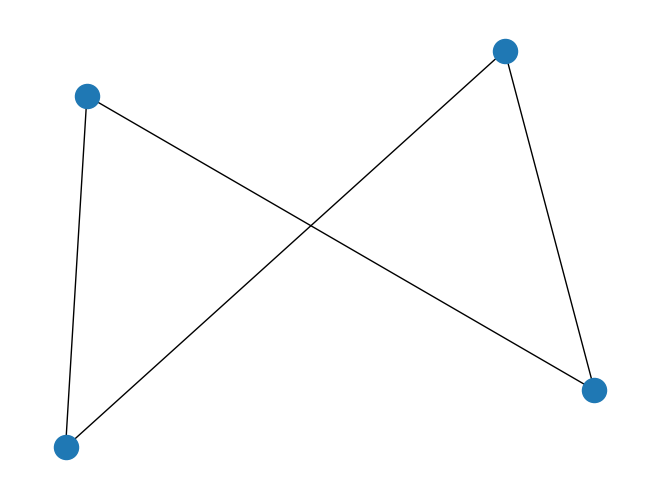

In [29]:
graph = nx.random_graphs.random_regular_graph(2, n)
nx.draw(graph)

Here we call the ``train()`` method. Set `steps=100` to train the model 100 times:

In [30]:
s2list, costlist, gradlist = train(
            HeisenbergModel(1, 1, graph=graph),
            circ,
            steps=100,
            eta=1e-1,
            list_qubits2keep=[0, 1],
        )

100%|██████████| 100/100 [00:00<00:00, 1955.50it/s]


where `list_qubits2keep=[0, 1]` means we only keep the space of `q0` and `q1` and trace out the others when we calculate entanglement entropy.

Finally, we use `matplotlib.pyplot` to visualize the results:

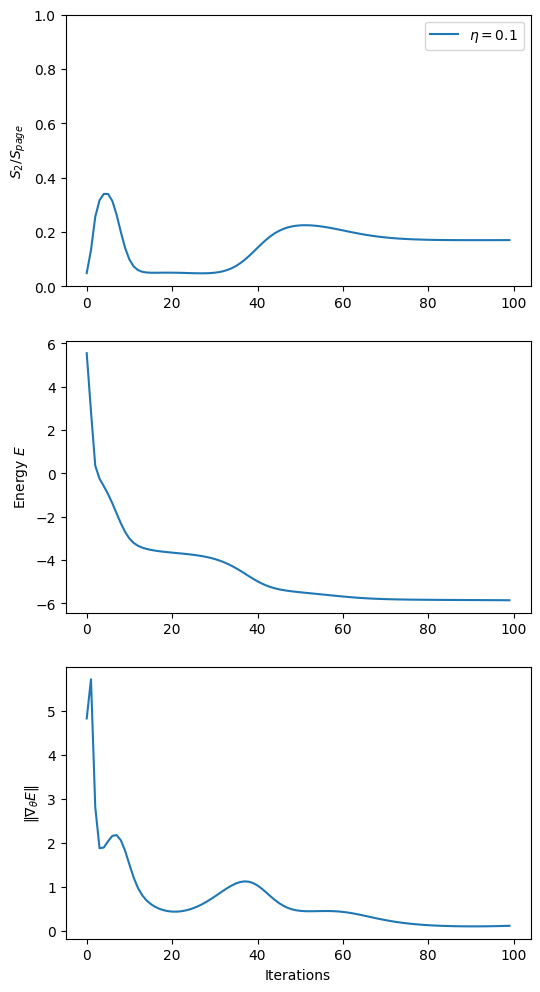

In [31]:
fig, axs = plt.subplots(3, figsize=(6, 12))
axs[0].plot(np.array(s2list) / (s_page(2, 6)), label=(r'$\eta=$' + f'{1e-1}'))
axs[1].plot(costlist)
axs[2].plot(gradlist)
axs[0].set(ylabel=r'$S_2 / S_{page}$',
               ylim=(0, 1))
axs[1].set(ylabel=r'Energy $E$')
axs[2].set(ylabel=r'$\Vert \nabla_\theta E \Vert$',
            xlabel='Iterations')
axs[0].legend(loc='upper right')

This result is consistent with the paper.

To find out more about MindQuantum's API, please click on [https://mindspore.cn/mindquantum/](https://mindspore.cn/mindquantum/).